In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
training_csv='./melanoma-image-data/train.csv'
test_csv='./melanoma-image-data/test.csv'
train_dataframe=pd.read_csv(training_csv)
test_dataframe=pd.read_csv(test_csv)
train_dataframe.head(7)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0


In [4]:
train_dataframe['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [5]:
benign_data=train_dataframe[train_dataframe['target']==0]
maligant_data=train_dataframe[train_dataframe['target']==1]

benign_data=benign_data.reset_index()
maligant_data=maligant_data.reset_index()

print(benign_data.shape[0])
print(maligant_data.shape[0])

32542
584


In [6]:
#train_bening_data
train_benign_dir='./melanoma-image-data/train/train/benign/'
data_benign = []
labels_benign =[]


train_maligant_dir='./melanoma-image-data/train/train/malignant/'
data_maligant = []
labels_maligant =[]

for i in range(benign_data.shape[0]):
    data_benign.append(train_benign_dir+benign_data['image_name'].iloc[i]+'.jpg')
    labels_benign.append(benign_data['target'].iloc[i])
df_benign=pd.DataFrame(data_benign)
df_benign.columns=['images']
df_benign['target']=labels_benign


for i in range(maligant_data.shape[0]):
    data_maligant.append(train_maligant_dir+maligant_data['image_name'].iloc[i]+'.jpg')
    labels_maligant.append(maligant_data['target'].iloc[i])
df_maligant=pd.DataFrame(data_maligant)
df_maligant.columns=['images']
df_maligant['target']=labels_maligant

print(df_benign.shape)
print(df_maligant.shape)

df=pd.concat([df_benign,df_maligant])
df.shape

(32542, 2)
(584, 2)


(33126, 2)

In [7]:
test_dir='./melanoma-image-data/test/test/unkown/'
test_data = []
for i in range(test_dataframe.shape[0]):
    test_data.append(test_dir + test_dataframe['image_name'].iloc[i]+'.jpg')
df_test_kaggle=pd.DataFrame(test_data)
df_test_kaggle.columns=['images']
df_test_kaggle.shape
df_test_kaggle

,images
0,./melanoma-image-data/test/test/unkown/ISIC_00...
1,./melanoma-image-data/test/test/unkown/ISIC_00...
2,./melanoma-image-data/test/test/unkown/ISIC_00...
3,./melanoma-image-data/test/test/unkown/ISIC_00...
4,./melanoma-image-data/test/test/unkown/ISIC_00...
...,...
10977,./melanoma-image-data/test/test/unkown/ISIC_99...
10978,./melanoma-image-data/test/test/unkown/ISIC_99...
10979,./melanoma-image-data/test/test/unkown/ISIC_99...
10980,./melanoma-image-data/test/test/unkown/ISIC_99...


In [8]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(df['images'],df['target'],test_size=0.2,random_state=42,stratify=df['target'])

train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
val_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_gen['image_dir'],train_gen['target'],test_size=0.1,random_state=42,stratify=train_gen['target'])

y_test_conf=y_test

train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
test_gen = pd.DataFrame({'image_dir': x_test, 'target': y_test})

In [10]:
from keras.layers import Input,Lambda,Dense,Flatten,Conv2D, MaxPooling2D, Dropout
from keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob

from keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.activations import sigmoid
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras import optimizers
import tensorflow as tf
#from keras.metrics import AUC

2023-03-20 06:55:30.230516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 06:55:33.865471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 06:55:33.865553: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 06:55:42.517478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range = 0.2,
                                   fill_mode ='nearest',
                                   horizontal_flip=True)
val_datagen=ImageDataGenerator(preprocessing_function =preprocess_input)
test_datagen =ImageDataGenerator(preprocessing_function =preprocess_input)


train_generator = train_datagen.flow_from_dataframe(
    train_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    val_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')


test_generator = test_datagen.flow_from_dataframe(
    test_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw',
    shuffle=False

)


Found 23850 validated image filenames.
Found 6626 validated image filenames.
Found 2650 validated image filenames.


In [12]:
train_gen.shape,val_gen.shape,test_gen.shape

((23850, 2), (6626, 2), (2650, 2))

In [13]:

base_model= EfficientNetV2S(weights='imagenet',input_shape=(224,224,3),include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
layer_top=Flatten()(base_model.output)
layer_top=layers.Dense(1, activation = 'sigmoid')(layer_top)

model =Model(inputs=base_model.input,outputs=layer_top)
#model.summary()

2023-03-20 06:55:56.784696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 06:55:56.784769: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 06:55:56.784816: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skin-cancer-v2): /proc/driver/nvidia/version does not exist
2023-03-20 06:55:56.798415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
opt = Adam(lr=0.00001)
auc = tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', metrics=[auc],optimizer=opt)

In [38]:

from datetime import datetime


from keras.callbacks import ModelCheckpoint,EarlyStopping

mc = ModelCheckpoint(filepath='EfficientNet_Imbalanced_AUC_model1.h5',
                     monitor='auc_7',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_7', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=103,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2942s 8s/step - loss: 0.0779 - auc_7: 0.7833 - val_loss: 0.0714 - val_auc_7: 0.8563
Epoch 2/30
372/372 [==============================] - 2865s 8s/step - loss: 0.0763 - auc_7: 0.8084 - val_loss: 0.0717 - val_auc_7: 0.8527
Epoch 3/30
372/372 [==============================] - 2914s 8s/step - loss: 0.0763 - auc_7: 0.8087 - val_loss: 0.0707 - val_auc_7: 0.8577
Epoch 4/30
372/372 [==============================] - 2883s 8s/step - loss: 0.0742 - auc_7: 0.8209 - val_loss: 0.0708 - val_auc_7: 0.8554
Epoch 5/30
372/372 [==============================] - 2973s 8s/step - loss: 0.0759 - auc_7: 0.8076 - val_loss: 0.0705 - val_auc_7: 0.8655
Epoch 6/30
372/372 [==============================] - 2933s 8s/step - loss: 0.0742 - auc_7: 0.8295 - val_loss: 0.0706 - val_auc_7: 0.8603
Epoch 7/30
372/372 [==============================] - 2968s 8s/step - loss: 0.0747 - auc_7: 0.8181 - val_loss: 0.0706 - val_auc_7: 0.8656
Training completed in time:  5:41:

In [39]:
# Load best fit model
imbalanced_model = load_model('EfficientNet_Imbalanced_AUC_model1.h5')

results = imbalanced_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


42/42 [==============================] - 231s 5s/step - loss: 0.0763 - auc_7: 0.8479
 Test loss and accuracy are [0.0763053372502327, 0.8478596210479736]


In [40]:
# Get prediction
imbalanced_pred = imbalanced_model.predict(test_generator,verbose = 1)
print(imbalanced_pred)

42/42 [==============================] - 235s 5s/step
[[0.00123693]
 [0.00944201]
 [0.00014672]
 ...
 [0.03425646]
 [0.00030419]
 [0.0111375 ]]


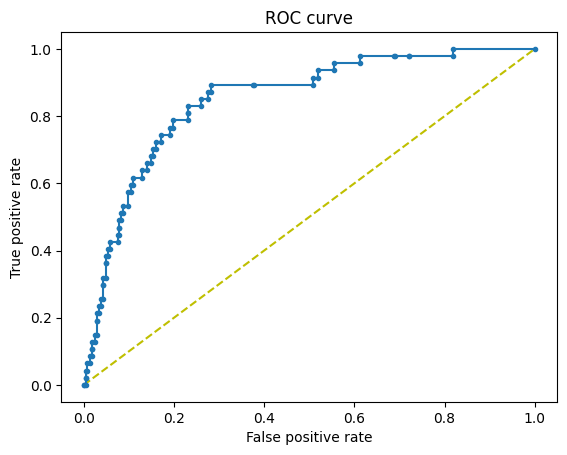

Area under curve, AUC =  0.850352702691657


In [41]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, imbalanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

# For kaggle compitition test

In [16]:

kaggle_test_path='./melanoma-image-data/test/test'
test_set_kaggle = test_datagen.flow_from_directory(kaggle_test_path,
                                             target_size = (224,224),
                                             batch_size = 32,
                                             class_mode = 'categorical',
                                             shuffle=False   )

test_set_kaggle.reset()



Found 10982 images belonging to 1 classes.


In [52]:
kaggle_pred_test = imbalanced_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


344/344 [==============================] - 1196s 3s/step
[[0.00200068]
 [0.09539575]
 [0.08007228]
 ...
 [0.00456134]
 [0.01582695]
 [0.00107455]]


In [55]:
# Malignent Prediction
imbalanced_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    imbalanced_predict_malignent.append(1-kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
imbalanced_np_malignent=np.asarray(imbalanced_predict_malignent, dtype=None)
imbalanced_np_malignent=imbalanced_np_malignent.ravel()

In [56]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":imbalanced_np_malignent})
results.to_csv("efficientNetV2_imbalanced_lr4_final_resultsV1.csv",index=False)

# With weighted focal loss

In [13]:
train_gen['target'].value_counts()

0    23430
1      420
Name: target, dtype: int64

In [14]:
def calculate_alpha(beta = 0.999):
     bening_sample=[23430,420]
     effective_num=1-np.power(beta,bening_sample)
     weights=(1.0-beta)/np.array(effective_num)
     weights=weights/np.sum(weights)*2
     return weights

alpha=calculate_alpha()
print(alpha[0])
print(alpha[1])

0.5108978868851661
1.4891021131148336


In [15]:
opt = Adam(lr=0.0001)
auc = tf.keras.metrics.AUC()

model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(
    alpha=alpha[0],
    gamma=1),
    optimizer = opt,
    metrics =[auc])


/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [48]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='EfficientNet_focal_AUC_model1.h5',
                     monitor='auc_9',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_9', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=103,
    verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2974s 8s/step - loss: 0.0487 - auc_9: 0.7863 - val_loss: 0.0459 - val_auc_9: 0.8391
Epoch 2/30
372/372 [==============================] - 2934s 8s/step - loss: 0.0491 - auc_9: 0.7854 - val_loss: 0.0450 - val_auc_9: 0.8130
Epoch 3/30
372/372 [==============================] - 2941s 8s/step - loss: 0.0472 - auc_9: 0.7849 - val_loss: 0.0457 - val_auc_9: 0.8327
Epoch 4/30
372/372 [==============================] - 2997s 8s/step - loss: 0.0461 - auc_9: 0.8065 - val_loss: 0.0479 - val_auc_9: 0.8385
Epoch 5/30
372/372 [==============================] - 2986s 8s/step - loss: 0.0466 - auc_9: 0.8104 - val_loss: 0.0468 - val_auc_9: 0.8429
Epoch 6/30
372/372 [==============================] - 3013s 8s/step - loss: 0.0472 - auc_9: 0.8118 - val_loss: 0.0450 - val_auc_9: 0.8411
Epoch 7/30
372/372 [==============================] - 3033s 8s/step - loss: 0.0444 - auc_9: 0.8297 - val_loss: 0.0493 - val_auc_9: 0.8078
Epoch 8/30
372/372 [==============

In [16]:
#load best model
from keras.models import load_model

# Load best fit model
focalloss_model = load_model('EfficientNet_focal_AUC_model1.h5')

results = focalloss_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 359s 8s/step - loss: 0.0527 - auc_9: 0.8077
 Test loss and accuracy are [0.052650682628154755, 0.8077219128608704]


In [17]:
imbalanced_pred = focalloss_model.predict(test_generator)
print(imbalanced_pred)

42/42 [==============================] - 241s 6s/step
[[0.04594717]
 [0.02712582]
 [0.00789688]
 ...
 [0.33940557]
 [0.01348025]
 [0.14673159]]


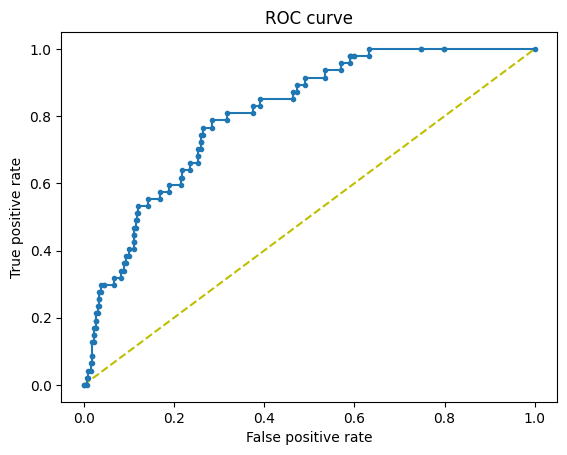

Area under curve, AUC =  0.807930293196884


In [18]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, imbalanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [21]:
kaggle_pred_test = focalloss_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


344/344 [==============================] - 1001s 3s/step
[[0.05081168]
 [0.0524926 ]
 [0.00754605]
 ...
 [0.4892098 ]
 [0.05391057]
 [0.2586366 ]]


In [22]:
# Malignent Prediction
focalloss_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    focalloss_predict_malignent.append(kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
focalloss_np_malignent=np.asarray(focalloss_predict_malignent, dtype=None)
focalloss_np_malignent=focalloss_np_malignent.ravel()

In [23]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":focalloss_np_malignent})
results.to_csv("efficientNetV2_focalloss_beta_resultsV1.csv",index=False)

# With class balanced 

In [53]:
opt = Adam(lr=0.0001)
auc = tf.keras.metrics.AUC()
model.compile(loss='binary_crossentropy', metrics=[auc],optimizer=opt)

In [54]:
x_train, y_train=next(train_generator)

In [56]:
train_classes=y_train
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = np.unique(train_classes),
                                        y = train_classes
) 
class_weights = dict(zip(np.unique(train_classes),class_weights))
class_weights

{0: 0.5161290322580645, 1: 16.0}

In [57]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='EfficientNet_balanced_inverse_AUC_model1.h5',
                     monitor='auc_11',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc_11', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=372,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=100,
    class_weight=class_weights,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
372/372 [==============================] - 2961s 8s/step - loss: 0.3981 - auc_11: 0.8286 - val_loss: 0.1906 - val_auc_11: 0.8495
Epoch 2/30
372/372 [==============================] - 2896s 8s/step - loss: 0.3670 - auc_11: 0.8569 - val_loss: 0.3613 - val_auc_11: 0.8461
Epoch 3/30
372/372 [==============================] - 2871s 8s/step - loss: 0.3588 - auc_11: 0.8648 - val_loss: 0.2239 - val_auc_11: 0.8542
Epoch 4/30
372/372 [==============================] - 2936s 8s/step - loss: 0.3707 - auc_11: 0.8593 - val_loss: 0.3032 - val_auc_11: 0.8431
Epoch 5/30
372/372 [==============================] - 2943s 8s/step - loss: 0.3792 - auc_11: 0.8559 - val_loss: 0.1760 - val_auc_11: 0.8482
Training completed in time:  4:03:33.152658


In [58]:
#load best model
from keras.models import load_model

# Load best fit model
weighted_model = load_model('EfficientNet_balanced_inverse_AUC_model1.h5')

results = weighted_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 239s 6s/step - loss: 0.2441 - auc_11: 0.8370
 Test loss and accuracy are [0.24413014948368073, 0.8369720578193665]


In [59]:
balanced_pred = weighted_model.predict(test_generator)
print(balanced_pred)

42/42 [==============================] - 229s 5s/step
[[1.3940366e-02]
 [5.9773121e-03]
 [3.5052196e-04]
 ...
 [6.4780468e-01]
 [7.8646367e-04]
 [2.9895997e-01]]


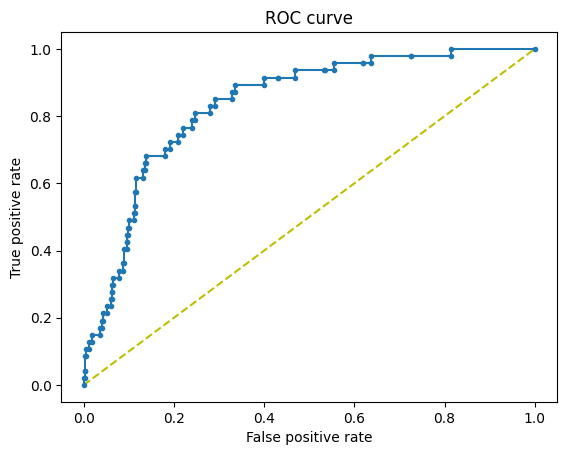

Area under curve, AUC =  0.8366124193851611


In [60]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, balanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [78]:
kaggle_pred_test = weighted_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


344/344 [==============================] - 823s 2s/step
[[2.3273547e-05]
 [1.8397883e-04]
 [4.3475265e-03]
 ...
 [5.6077940e-03]
 [1.9245984e-03]
 [2.5371981e-03]]


In [79]:
# Malignent Prediction
weighted_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    weighted_predict_malignent.append(1-kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
weighted_predict_malignent=np.asarray(weighted_predict_malignent, dtype=None)
weighted_predict_malignent=weighted_predict_malignent.ravel()

In [80]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":weighted_predict_malignent})
results.to_csv("efficientNetV2_weighted_resultsV1.csv",index=False)

# Model with average / sum Ensemble

In [14]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('EfficientNet_focal_AUC_model1.h5')
model2 = load_model('EfficientNet_balanced_inverse_AUC_model1.h5')

models = [model1, model2]

ensemble_pred = [model.predict(test_generator) for model in models]
ensemble_pred=np.array(ensemble_pred)

KeyboardInterrupt: 

In [15]:
weights = [0.2, 0.8]

In [16]:
weighted_preds = np.tensordot(ensemble_pred, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)

[0.0139191  0.00945709 0.00130398 ... 0.54382527 0.00098657 0.30221276]


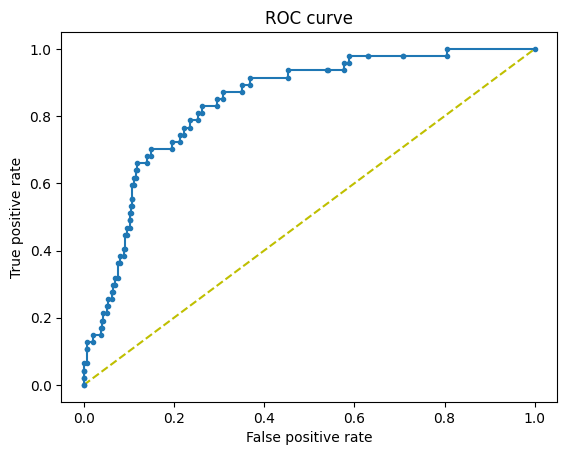

Area under curve, AUC =  0.8411570936971253


In [17]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, weighted_ensemble_prediction)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [18]:
balanced_pred_conf=weighted_ensemble_prediction
for i in range(len(balanced_pred_conf)):
    if (balanced_pred_conf[i]>0.5):
        balanced_pred_conf[i] = 1
    else:
        balanced_pred_conf[i] = 0
balanced_pred_conf

array([0., 0., 0., ..., 1., 0., 0.])

<AxesSubplot:>

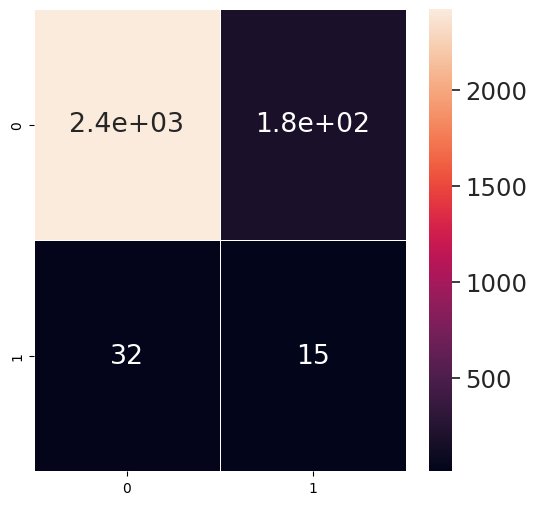

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_conf, balanced_pred_conf)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [15]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('EfficientNet_focal_AUC_model1.h5')
model2 = load_model('EfficientNet_balanced_inverse_AUC_model1.h5')

models = [model1, model2]

In [17]:
kaggle_pred_test= [model.predict(test_set_kaggle,verbose=1) for model in models]
kaggle_pred_test=np.array(kaggle_pred_test)

weights = [0.2, 0.8]
weighted_preds = np.tensordot(kaggle_pred_test, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)

344/344 [==============================] - 1488s 4s/step
[0.03192732 0.02972073 0.00935705 ... 0.63883145 0.02811053 0.01308768]


In [18]:
ensemble_predict_malignent=np.asarray(weighted_ensemble_prediction, dtype=None)
ensemble_predict_malignent=ensemble_predict_malignent.ravel()

import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":ensemble_predict_malignent})
results.to_csv("EfficientNet_Ensemble_results_final.csv",index=False)